<h1>Phase 4 Final Project Submission</h1>

<h3>Student Name: Jason Lombino</h3>
<hr>

<h1>Business Problem</h1>

<h1>Libraries</h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from skimage.segmentation import mark_boundaries
from lime import lime_image
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import applications
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

<h1>Data

In [2]:
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
val_path = 'chest_xray/val'

In [3]:
train_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=45,
    zoom_range=0.3
)

train_ds = train_generator.flow_from_directory(
    train_path,
    target_size=(256,256),
    class_mode='binary',
)

train_norm = len(os.listdir(train_path + '/NORMAL'))
train_sick = len(os.listdir(train_path + '/PNEUMONIA'))

Found 4175 images belonging to 2 classes.


In [4]:
val_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_ds = val_generator.flow_from_directory(
    val_path,
    target_size=(256,256),
    class_mode='binary',
    shuffle=False
)

val_norm = len(os.listdir(val_path + '/NORMAL'))
val_sick = len(os.listdir(val_path + '/PNEUMONIA'))

Found 1057 images belonging to 2 classes.


In [5]:
test_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_ds = test_generator.flow_from_directory(
    test_path,
    target_size=(256,256),
    class_mode='binary',
    shuffle=False
)

test_norm = len(os.listdir(test_path + '/NORMAL'))
test_sick = len(os.listdir(test_path + '/PNEUMONIA'))

Found 624 images belonging to 2 classes.


<h1>Data Visualizations

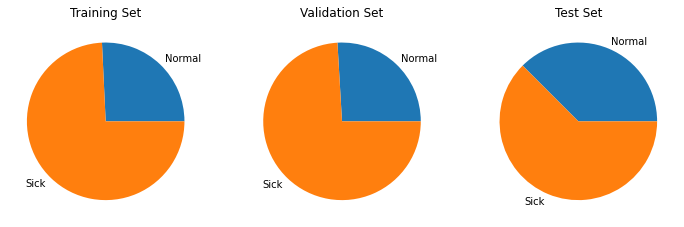

In [6]:
data_fig, data_ax = plt.subplots(1,3,figsize=(12,4))
data_ax[0].pie([train_norm,train_sick],labels=['Normal','Sick']);
data_ax[0].set_title('Training Set');

data_ax[1].pie([val_norm,val_sick],labels=['Normal','Sick']);
data_ax[1].set_title('Validation Set');

data_ax[2].pie([test_norm,test_sick],labels=['Normal','Sick']);
data_ax[2].set_title('Test Set');

data_fig.set_facecolor('#FFFFFF')

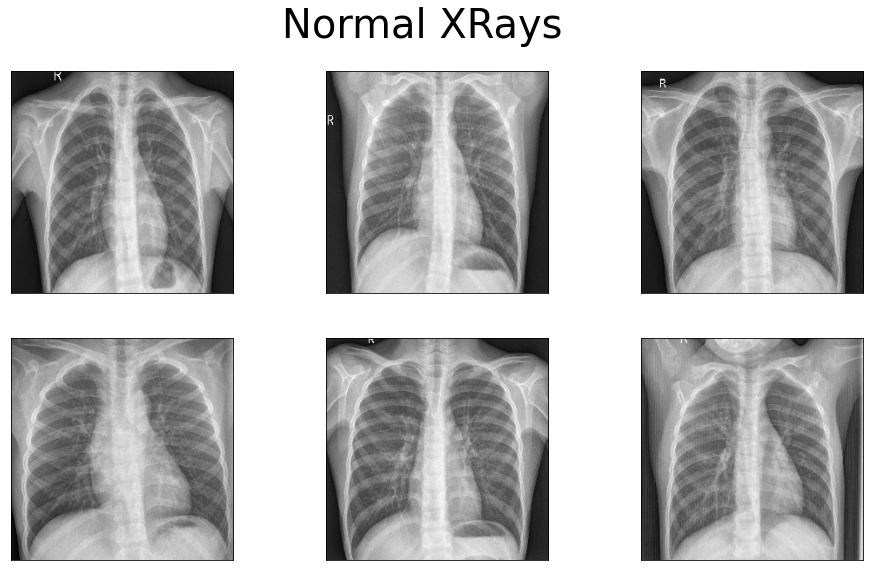

In [7]:
normal_images = []
for image in test_ds[0][0][:6]:
    normal_images.append(image)

normal_fig,normal_ax = plt.subplots(2,3,figsize=(16,9))
for idx,image in enumerate(normal_images[:6]):
        active_axis = normal_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
normal_fig.set_facecolor('#FFFFFF')
normal_fig.suptitle('Normal XRays', fontsize=40);

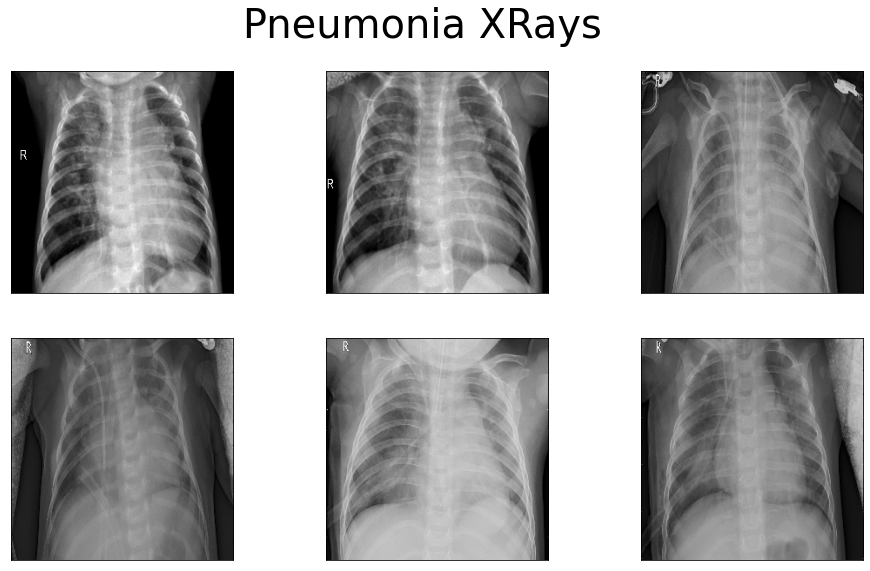

In [8]:
sick_images = []
for image in test_ds[len(test_ds)-1][0][:6]:
    sick_images.append(image)

sick_fig,sick_ax = plt.subplots(2,3,figsize=(16,9))
for idx,image in enumerate(sick_images[:6]):
        active_axis = sick_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
sick_fig.set_facecolor('#FFFFFF')
sick_fig.suptitle('Pneumonia XRays', fontsize=40);

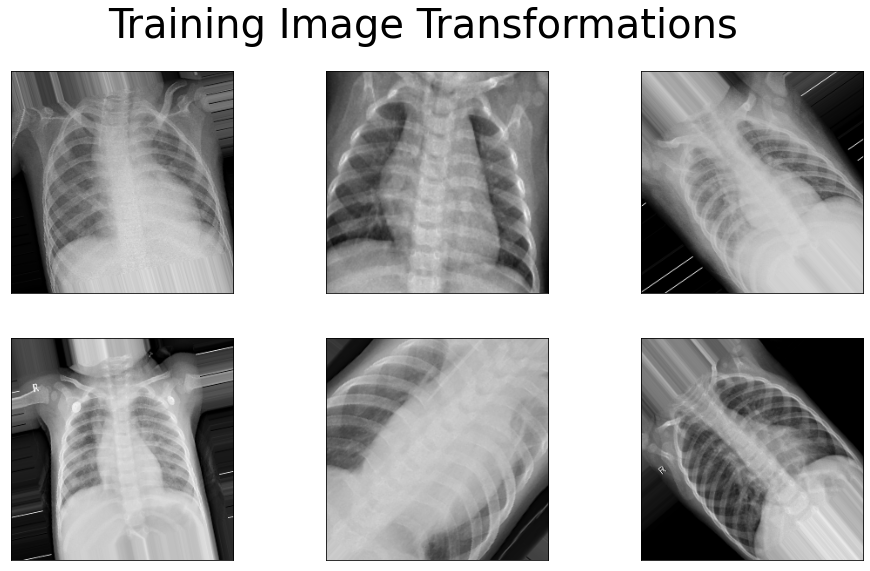

In [9]:
train_prep = train_ds[0][0][:6]

train_fig,train_ax = plt.subplots(2,3,figsize=(16,9))
for idx,image in enumerate(train_prep[:6]):
        active_axis = train_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
train_fig.set_facecolor('#FFFFFF')
train_fig.suptitle('Training Image Transformations', fontsize=40);

<h1>Modeling</h1>

Various models results

| Model Name                                     | % Train Accuracy | % Val Accuracy | 
|------------------------------------------------|------------------|----------------|
| * Basic CNN                                      | 98.8             | 96.7           | 
| Basic CNN Image Preprocessing                  | 93.5             | 91.2           | 
| Larger CNN                                     | 93.5             | 94.0           | 
| Larger CNN tanh Activation                     | 74.3             | 74.1           | 
| Larger CNN Dropout                             | 93.3             | 94.0           | 
| Larger CNN Larger Stride                       | 95.3             | 93.4           | 
| Larger CNN Double Convolutional Layers         | 95.5             | 94.0           | 
| Even Larger CNN                                | 94.8             | 94.5           | 
| Transfer Learning Xception                     | 96.6             | 94.0           | 
| Transfer Learning VGG16                        | 95.0             | 95.7           | 
| Transfer Learning VGG16 Decaying Learning Rate | 94.7             | 94.2           |

<h1>Second Best Model (Even Larger CNN)</h1>

In [10]:
nt_model = models.Sequential()

nt_model.add(layers.Conv2D(32, (1, 1), activation='relu',padding='same',
                        input_shape=(256, 256, 3)))     
nt_model.add(layers.Conv2D(32, (1, 1), activation='relu',padding='same'))                
nt_model.add(layers.MaxPooling2D((2, 2)))

nt_model.add(layers.Conv2D(64, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(64, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

nt_model.add(layers.Conv2D(128, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(128, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

nt_model.add(layers.Conv2D(256, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(256, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

nt_model.add(layers.Flatten())
nt_model.add(layers.Dense(512, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(512, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(256, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(128, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(64, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(32, activation='relu'))
nt_model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
nt_checkpoint = callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='save_data/nt_model.hdf5',
    save_best_only=True,
    verbose=0
)

nt_callbacks = [nt_checkpoint]

use_metrics = [metrics.BinaryAccuracy(),\
                metrics.Precision(),\
                metrics.Recall()]

In [12]:
nt_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=[use_metrics]
)

print(nt_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      2112      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      4160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       8

In [13]:
with tf.device('/CPU:0'):
    nt_history = nt_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        callbacks=nt_callbacks
    )

nt_model.load_weights('save_data/nt_model.hdf5')

Epoch 1/5
131/131 [==============================] - 107s 819ms/step - loss: 0.5541 - binary_accuracy: 0.7301 - precision: 0.7409 - recall: 0.9787 - val_loss: 0.5097 - val_binary_accuracy: 0.7408 - val_precision: 0.7408 - val_recall: 1.0000
Epoch 2/5
131/131 [==============================] - 106s 808ms/step - loss: 0.4595 - binary_accuracy: 0.7523 - precision: 0.7703 - recall: 0.9497 - val_loss: 0.3946 - val_binary_accuracy: 0.8269 - val_precision: 0.9043 - val_recall: 0.8570
Epoch 3/5
131/131 [==============================] - 106s 808ms/step - loss: 0.3087 - binary_accuracy: 0.8745 - precision: 0.8980 - recall: 0.9374 - val_loss: 0.2769 - val_binary_accuracy: 0.8789 - val_precision: 0.8922 - val_recall: 0.9515
Epoch 4/5
131/131 [==============================] - 106s 807ms/step - loss: 0.2712 - binary_accuracy: 0.8963 - precision: 0.9208 - recall: 0.9413 - val_loss: 0.1898 - val_binary_accuracy: 0.9158 - val_precision: 0.9887 - val_recall: 0.8966
Epoch 5/5
131/131 [=================

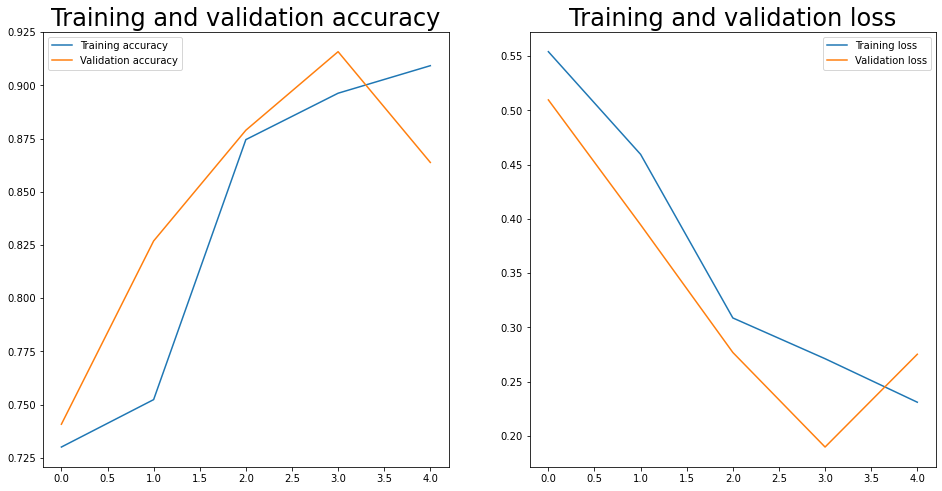

In [14]:
nt_acc = nt_history.history['binary_accuracy']
nt_val_acc = nt_history.history['val_binary_accuracy']
nt_loss = nt_history.history['loss']
nt_val_loss = nt_history.history['val_loss']
nt_epochs = range(len(nt_acc))

nt_fig,nt_ax = plt.subplots(1,2,figsize=(16,8))
nt_ax[0].plot(nt_epochs, nt_acc, label='Training accuracy');
nt_ax[0].plot(nt_epochs, nt_val_acc, label='Validation accuracy');
nt_ax[0].set_title('Training and validation accuracy',fontsize=24);
nt_ax[0].legend();

nt_ax[1].plot(nt_epochs, nt_loss, label='Training loss');
nt_ax[1].plot(nt_epochs, nt_val_loss, label='Validation loss');
nt_ax[1].set_title('Training and validation loss',fontsize=24);
nt_ax[1].legend();

In [15]:
nt_train_results = nt_model.evaluate(train_ds)

131/131 [==============================] - 55s 421ms/step - loss: 0.1916 - binary_accuracy: 0.9265 - precision: 0.9586 - recall: 0.9416


In [16]:
nt_val_res = nt_model.evaluate(val_ds)

34/34 [==============================] - 8s 240ms/step - loss: 0.1898 - binary_accuracy: 0.9158 - precision: 0.9887 - recall: 0.8966


In [17]:
nt_test_res = nt_model.evaluate(test_ds)

20/20 [==============================] - 4s 203ms/step - loss: 0.3883 - binary_accuracy: 0.8846 - precision: 0.8897 - recall: 0.9308


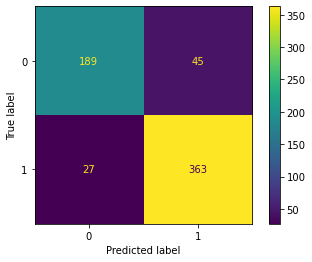

In [18]:
nt_test_predictions = np.round(nt_model.predict(test_ds),0)
test_actual = test_ds.labels
nt_c_matrix = confusion_matrix(test_actual,nt_test_predictions)
ConfusionMatrixDisplay(nt_c_matrix).plot()

<h1>Best Model (Transfer Learning with VGG16)

In [19]:
vgg_base = applications.VGG16(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False
)

vgg_base.trainable = False

In [20]:
tx_model = models.Sequential()

tx_model.add(vgg_base)                   
tx_model.add(layers.Flatten())
tx_model.add(layers.Dense(512, activation='relu'))
tx_model.add(layers.Dense(256, activation='relu'))
tx_model.add(layers.Dense(128, activation='relu'))
tx_model.add(layers.Dense(64, activation='relu'))
tx_model.add(layers.Dense(1, activation='sigmoid'))

for layer in tx_model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_1 True
dense_7 True
dense_8 True
dense_9 True
dense_10 True
dense_11 True


In [21]:
tx_checkpoint = callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='save_data/tx_model.hdf5',
    save_best_only=True,
    verbose=0
)

tx_callbacks = [tx_checkpoint]

use_metrics = [metrics.BinaryAccuracy(),\
                metrics.Precision(),\
                metrics.Recall()]

In [22]:
scheduler = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_rate=0.96,
    decay_steps=2500
)

In [23]:
tx_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=scheduler),
    metrics=[use_metrics]
)

print(tx_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [24]:
with tf.device('/CPU:0'):
    tx_history = tx_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        callbacks=tx_callbacks
    )

tx_model = models.load_model('save_data/tx_model.hdf5')

Epoch 1/5
131/131 [==============================] - 197s 2s/step - loss: 0.2839 - binary_accuracy: 0.8857 - precision_1: 0.9186 - recall_1: 0.9284 - val_loss: 0.4489 - val_binary_accuracy: 0.8174 - val_precision_1: 1.0000 - val_recall_1: 0.7535
Epoch 2/5
131/131 [==============================] - 195s 1s/step - loss: 0.1714 - binary_accuracy: 0.9257 - precision_1: 0.9480 - recall_1: 0.9523 - val_loss: 0.3490 - val_binary_accuracy: 0.8827 - val_precision_1: 1.0000 - val_recall_1: 0.8416
Epoch 3/5
131/131 [==============================] - 195s 1s/step - loss: 0.1549 - binary_accuracy: 0.9406 - precision_1: 0.9582 - recall_1: 0.9619 - val_loss: 0.1413 - val_binary_accuracy: 0.9518 - val_precision_1: 0.9959 - val_recall_1: 0.9387
Epoch 4/5
131/131 [==============================] - 196s 1s/step - loss: 0.1490 - binary_accuracy: 0.9444 - precision_1: 0.9626 - recall_1: 0.9626 - val_loss: 0.3103 - val_binary_accuracy: 0.8912 - val_precision_1: 0.9985 - val_recall_1: 0.8544
Epoch 5/5
131/13

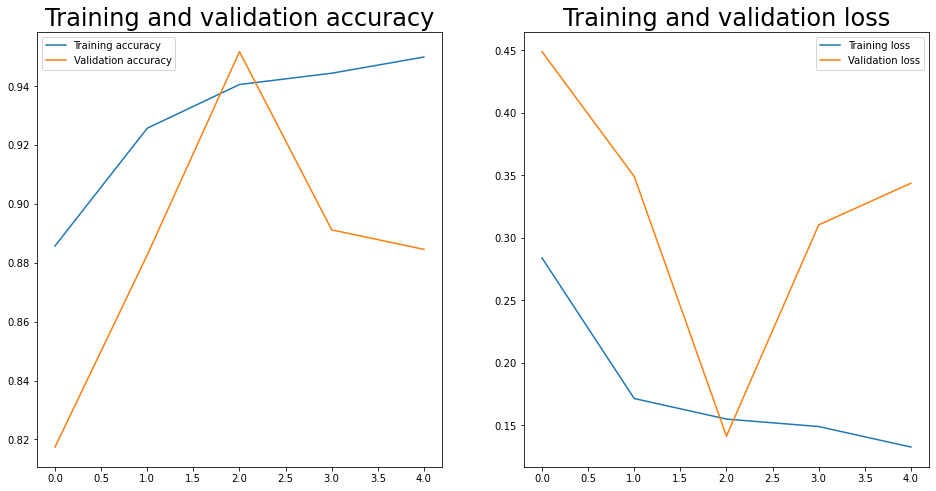

In [25]:
tx_acc = tx_history.history['binary_accuracy']
tx_val_acc = tx_history.history['val_binary_accuracy']
tx_loss = tx_history.history['loss']
tx_val_loss = tx_history.history['val_loss']
tx_epochs = range(len(tx_acc))

tx_fig,tx_ax = plt.subplots(1,2,figsize=(16,8))
tx_ax[0].plot(tx_epochs, tx_acc, label='Training accuracy');
tx_ax[0].plot(tx_epochs, tx_val_acc, label='Validation accuracy');
tx_ax[0].set_title('Training and validation accuracy',fontsize=24);
tx_ax[0].legend();

tx_ax[1].plot(tx_epochs, tx_loss, label='Training loss');
tx_ax[1].plot(tx_epochs, tx_val_loss, label='Validation loss');
tx_ax[1].set_title('Training and validation loss',fontsize=24);
tx_ax[1].legend();

In [26]:
tx_train_res = tx_model.evaluate(train_ds)

131/131 [==============================] - 154s 1s/step - loss: 0.1402 - binary_accuracy: 0.9473 - precision_1: 0.9436 - recall_1: 0.9881


In [27]:
tx_val_res = tx_model.evaluate(val_ds)

34/34 [==============================] - 38s 1s/step - loss: 0.1413 - binary_accuracy: 0.9518 - precision_1: 0.9959 - recall_1: 0.9387


In [28]:
tx_test_res = tx_model.evaluate(test_ds)

20/20 [==============================] - 22s 1s/step - loss: 0.2997 - binary_accuracy: 0.8910 - precision_1: 0.8578 - recall_1: 0.9897


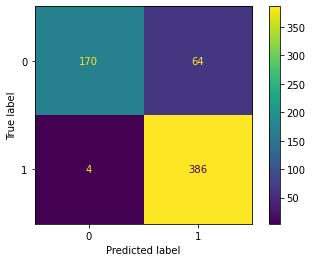

In [29]:
tx_test_predictions = np.round(tx_model.predict(test_ds),0)
test_actual = test_ds.labels
tx_c_matrix = confusion_matrix(test_actual,tx_test_predictions)
ConfusionMatrixDisplay(tx_c_matrix).plot()

<h1>Analysis of Results (Non transfer learning model)</h1>

In [30]:
explainer = lime_image.LimeImageExplainer()

<h1>True Positives

In [31]:
true_pos = []

for batch in range(len(test_ds)):
    for idx,image in enumerate(test_ds[batch][0]):
        if len(true_pos) >= 6:
            break
        else:
            if np.round(nt_model.predict(np.expand_dims(image,axis=0)),0) == 1 \
                and test_ds[batch][1][idx] == 1:
                true_pos.append(image)
    if len(true_pos) >= 6:
            break

100%|██████████| 1000/1000 [00:07<00:00, 127.06it/s]


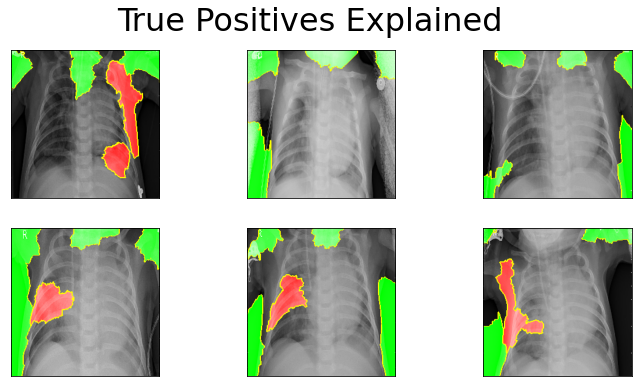

In [32]:
tp_fig, tp_ax = plt.subplots(2,3,figsize=(12,6))
for idx,image in enumerate(true_pos):
    active_axis = tp_ax[idx//3][idx%3]
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    explanation = explainer.explain_instance(
        image, nt_model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
    active_axis.imshow(mark_boundaries(temp, mask))
    active_axis.text
tp_fig.set_facecolor('#FFFFFF')
tp_fig.suptitle('True Positives Explained',fontsize=32);

<h1>True Negatives

In [33]:
true_neg = []

for batch in range(len(test_ds)):
    for idx,image in enumerate(test_ds[batch][0]):
        if len(true_neg) >= 6:
            break
        else:
            if np.round(nt_model.predict(np.expand_dims(image,axis=0)),0) == 0 \
                and test_ds[batch][1][idx] == 0:
                true_neg.append(image)
    if len(true_neg) >= 6:
            break

100%|██████████| 1000/1000 [00:07<00:00, 127.27it/s]


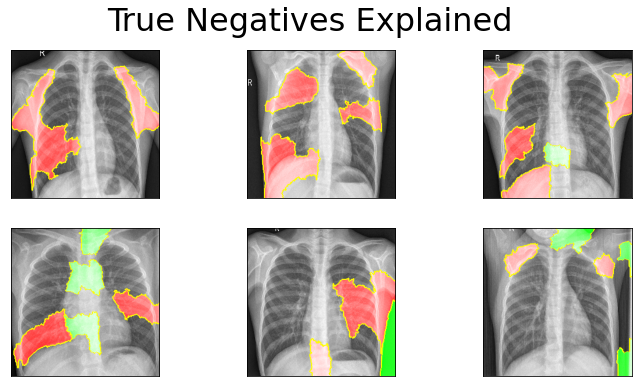

In [34]:
tn_fig, tn_ax = plt.subplots(2,3,figsize=(12,6))
for idx,image in enumerate(true_neg):
    active_axis = tn_ax[idx//3][idx%3]
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    explanation = explainer.explain_instance(
        image, nt_model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
    active_axis.imshow(mark_boundaries(temp, mask))
    active_axis.text
tn_fig.set_facecolor('#FFFFFF')
tn_fig.suptitle('True Negatives Explained',fontsize=32);

<h1>Fasle Positives

In [35]:
false_pos = []

for batch in range(len(test_ds)):
    for idx,image in enumerate(test_ds[batch][0]):
        if len(false_pos) >= 6:
            break
        else:
            if np.round(nt_model.predict(np.expand_dims(image,axis=0)),0) == 1 \
                and test_ds[batch][1][idx] == 0:
                false_pos.append(image)
    if len(false_pos) >= 6:
            break

100%|██████████| 1000/1000 [00:08<00:00, 123.63it/s]


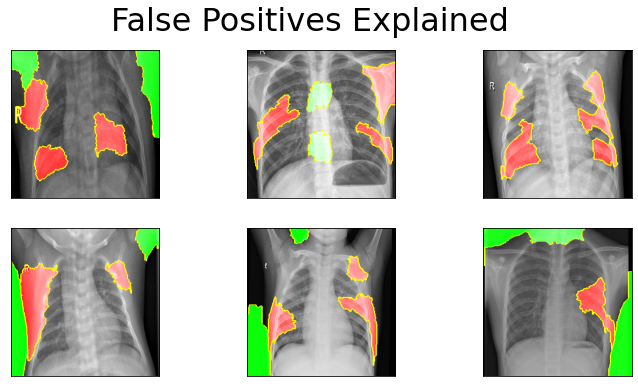

In [36]:
fp_fig, fp_ax = plt.subplots(2,3,figsize=(12,6))
for idx,image in enumerate(false_pos):
    active_axis = fp_ax[idx//3][idx%3]
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    explanation = explainer.explain_instance(
        image, nt_model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
    active_axis.imshow(mark_boundaries(temp, mask))
    active_axis.text
fp_fig.set_facecolor('#FFFFFF')
fp_fig.suptitle('False Positives Explained',fontsize=32);

<h1>False Negatives

In [37]:
false_neg = []

for batch in range(len(test_ds)):
    for idx,image in enumerate(test_ds[batch][0]):
        if len(false_neg) >= 6:
            break
        else:
            if np.round(nt_model.predict(np.expand_dims(image,axis=0)),0) == 0 \
                and test_ds[batch][1][idx] == 1:
                false_neg.append(image)
    if len(false_neg) >= 6:
            break

100%|██████████| 1000/1000 [00:08<00:00, 113.75it/s]


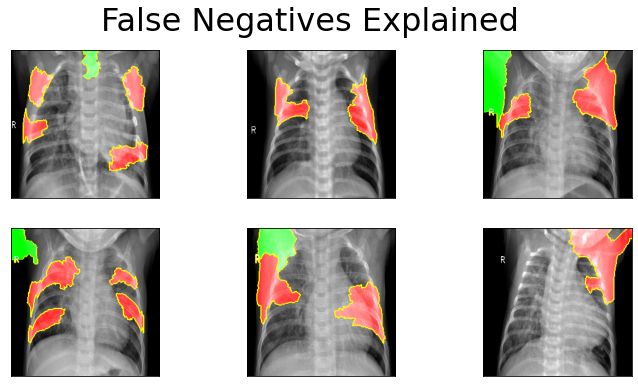

In [38]:
fn_fig, fn_ax = plt.subplots(2,3,figsize=(12,6))
for idx,image in enumerate(false_neg):
    active_axis = fn_ax[idx//3][idx%3]
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    explanation = explainer.explain_instance(
        image, nt_model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
    active_axis.imshow(mark_boundaries(temp, mask))
    active_axis.text
fn_fig.set_facecolor('#FFFFFF')
fn_fig.suptitle('False Negatives Explained',fontsize=32);

<h1>Intermediate Activations

In [39]:
nt_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      2112      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      4160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       8

In [40]:
layer_outputs = [layer.output for layer in nt_model.layers[:12]]

activation_model = models.Model(
    inputs = nt_model.input,
    outputs = layer_outputs
)

activations = activation_model.predict(np.expand_dims(test_ds[0][0][0],axis=0))

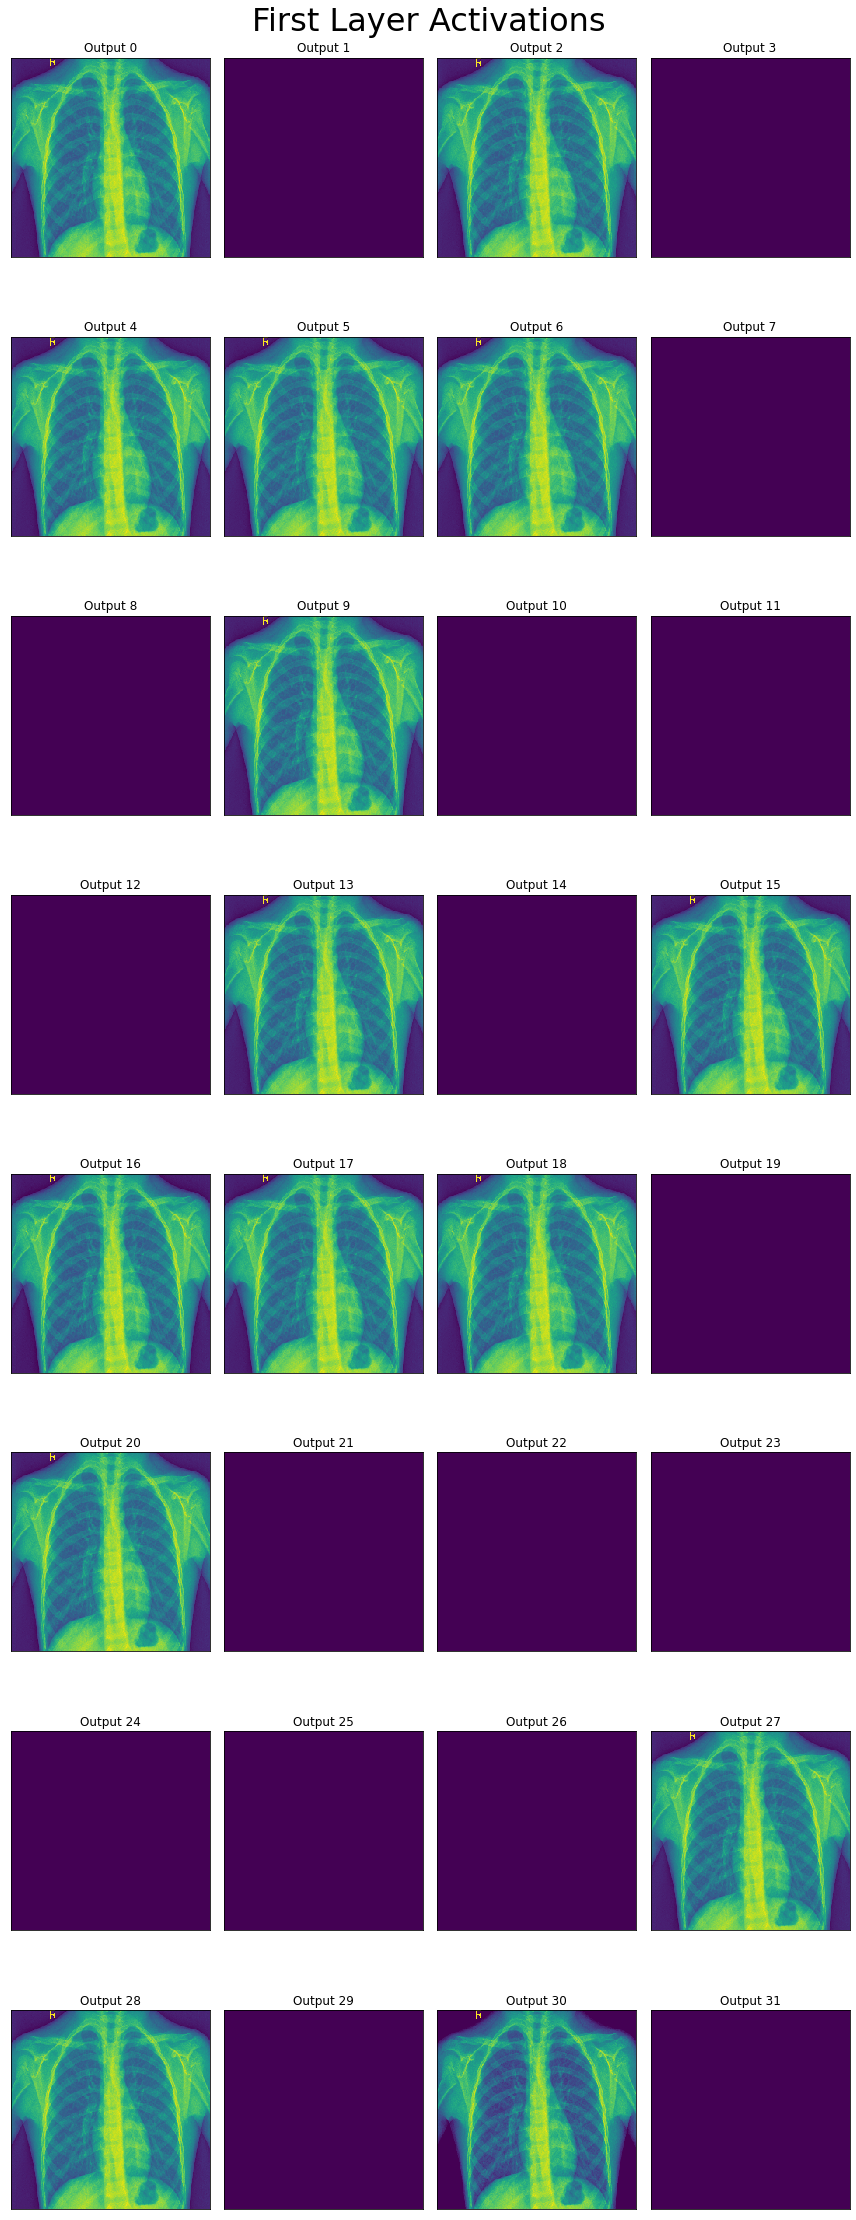

In [45]:
l0_fig, l0_ax = plt.subplots(8, 4, figsize=(12,32))
for idx in range(32):
    active_axis = l0_ax[idx//4, idx%4]
    first_layer_activation = activations[0]
    active_axis.matshow(first_layer_activation[0, :, :, idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    active_axis.set_title('Output ' + str(idx))
l0_fig.set_facecolor('#FFFFFF')
l0_fig.suptitle('First Layer Activations',fontsize=32);
l0_fig.tight_layout()

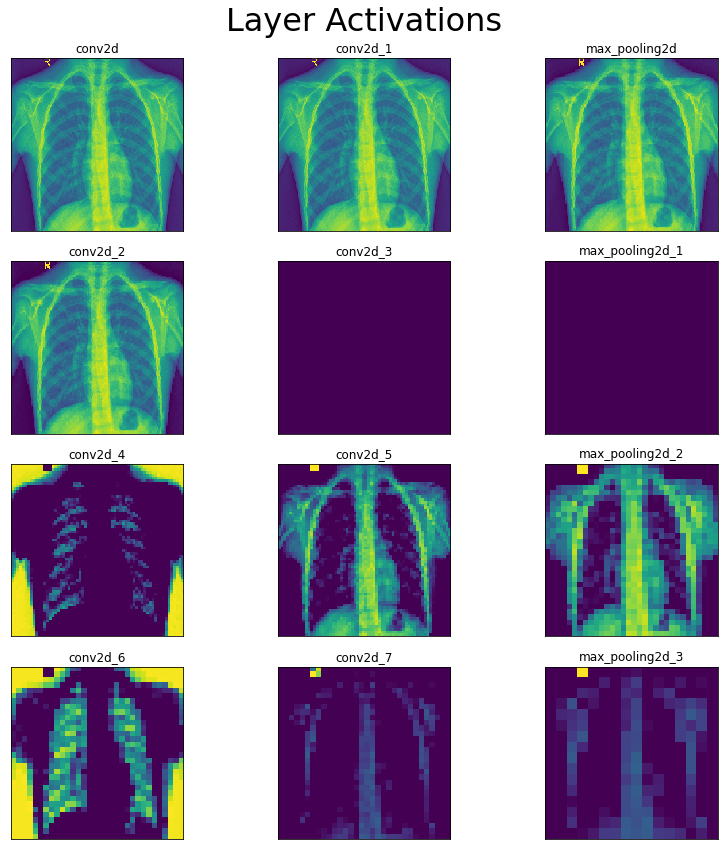

In [42]:
act_fig,act_ax = plt.subplots(4,3,figsize=(12,12))

layer_names = []
for layer in nt_model.layers[:12]:
    layer_names.append(layer.name)

for idx in range(12):
    active_axis = act_ax[idx//3][idx%3]
    cur_layer = activations[idx]
    active_axis.matshow(cur_layer[0,:,:,0])
    active_axis.set_title(layer_names[idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
act_fig.set_facecolor('#FFFFFF')
act_fig.suptitle('Layer Activations',fontsize=32);
act_fig.tight_layout()